<a href="https://colab.research.google.com/github/jinyjib98/moji_key/blob/main/AI_05_%EA%B9%80%ED%98%95%EC%A7%84_CS1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CodeStates Project 1

-----

## 인스타그램 포스팅 생성기 (po_sta)

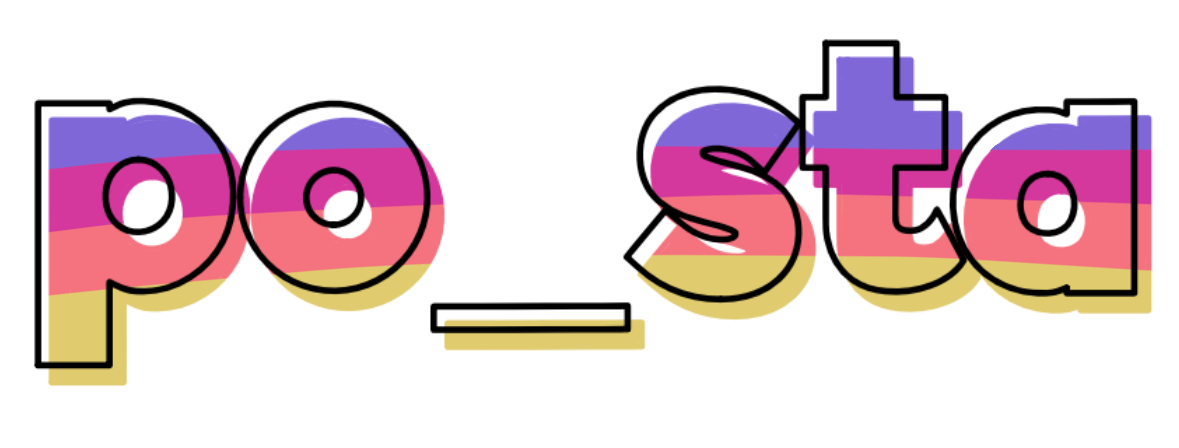

> 🤔 **문제 정의**

인스타그램은 현재 대표적인 SNS 플랫폼으로 많은 사람들이 각자의 일상, 감정을 공유함

인스타그램을 일기장처럼 사용하는 사람들도 존재

하지만 인스타그램의 단점은 포스팅을 위해 **사진이 필수적**이라는 점

**그렇다면 내가 작성한 텍스트에 대해 관련된 이미지와 해시태그까지 제공해주는 서비스가 있다면 어떨까?**

<br/>

> 🎯 **타겟층**

- 인스타그램을 일기처럼 사용하고 싶지만 사진을 고르기는 귀찮은 사람
- 통일성 있는 포스팅을 원하는 사람
- 막상 포스팅을 했는데 어떤 해시태그를 사용해야할지 고민인 사람

<br/>

> 💡 **서비스 내용**

- BERT 모델을 활용한 감정 분석을 통해 텍스트별 포스팅용 이미지 제시
- KeyBERT 모델을 통해 텍스트 관련 해시태그 추천

In [1]:
!pip install ktrain

     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 48.3 MB/s 
     |████████████████████████████████| 981 kB 67.2 MB/s 
     |████████████████████████████████| 263 kB 44.5 MB/s 
     |████████████████████████████████| 2.8 MB 41.3 MB/s 
     |████████████████████████████████| 1.2 MB 18.9 MB/s 
     |████████████████████████████████| 468 kB 36.7 MB/s 
     |████████████████████████████████| 61 kB 538 kB/s 
     |████████████████████████████████| 3.3 MB 19.2 MB/s 
     |████████████████████████████████| 895 kB 50.2 MB/s 
     |████████████████████████████████| 596 kB 50.9 MB/s 
  Created wheel for ktrain: filename=ktrain-0.28.3-py3-none-any.whl size=25292659 sha256=7bb3314d24d1f39a17f79a6548d7afb5c2ac1994ac1468826a1b1ff7db852cc2
  Stored in directory: /root/.cache/pip/wheels/6a/7e/c3/f46cdfc2b81c54424923b1405d7e670c35cacc11ada9a47b1c
  Created wheel for seqeval: filename=seqeval-0.0.19-py3-none-any.whl size=9929 sha256=89aef3d675d735e8

In [2]:
!pip install text_hammer
!pip install spacy==2.2.3

     |████████████████████████████████| 115 kB 5.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 10.4 MB 4.3 MB/s 
     |████████████████████████████████| 2.2 MB 37.6 MB/s 
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# import data
data = '/content/drive/MyDrive/Section6/cp_1/data/tweet_emotion.csv'
data2 = '/content/drive/MyDrive/Section6/cp_1/data/emoji/train.txt'
data3 = '/content/drive/MyDrive/Section6/cp_1/data/emoji/test.txt'

df = pd.read_csv(data)
df2 = pd.read_csv(data2, sep=';', names=['text', 'sentiment'])
df3 = pd.read_csv(data3, sep=';', names=['text', 'sentiment'])

In [15]:
df.shape, df2.shape, df3.shape

((40000, 3), (16000, 2), (2000, 2))

In [16]:
df.drop(columns='tweet_id', inplace=True)
df.rename(columns={'content':'text'}, inplace=True)
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,@tiffanylue i know i was listenin to bad habi...,empty
1,Layin n bed with a headache ughhhh...waitin o...,sadness
2,Funeral ceremony...gloomy friday...,sadness
3,wants to hang out with friends SOON!,enthusiasm
4,@dannycastillo We want to trade with someone w...,neutral


In [ ]:
df['sentiment'].unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [ ]:
df2['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
df['sentiment'].value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

In [6]:
df2['sentiment'].value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

In [7]:
df3['sentiment'].value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentiment, dtype: int64

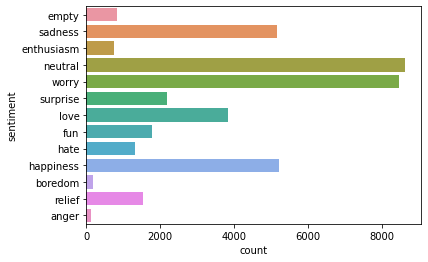

In [ ]:
sns.countplot(y='sentiment', data=df)

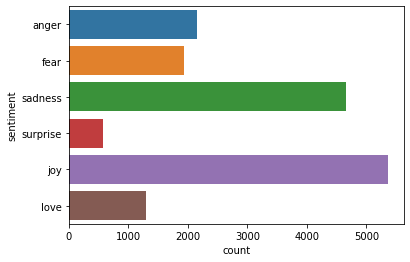

In [ ]:
sns.countplot(y='sentiment', data=df2, order=['anger', 'fear', 'sadness', 'surprise', 'joy', 'love'])

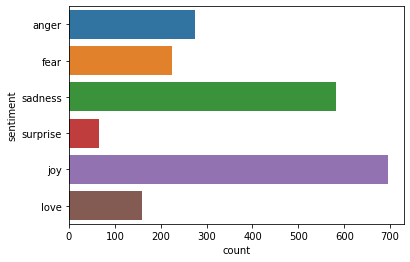

In [ ]:
sns.countplot(y='sentiment', data=df3, order=['anger', 'fear', 'sadness', 'surprise', 'joy', 'love'])

전체적으로 target인 감정의 종류가 너무 많아 어느정도 높은 성능을 얻기 위해서는 **비슷한 감정들끼리 묶어** target의 수를 줄이는 것이 필요할듯

-> 부정적인 감정은 `negative`, 긍정적인 감정은 `positive`, 그 외 애매한 감정들은 `neutral`로 나눌 것 

## surprise 처리

surprise의 경우 긍정적 - 부정적 모두 가능 -> 시간적 문제로 일단 이 감정에 해당하는 text들은 제거 후 모델링 진행할 예정

전체적으로 데이터 내 surprise의 비중이 크지 않아 큰 문제 없을 것으로 판단됨

In [ ]:
df[df['sentiment'] == 'surprise']

,text,sentiment
14,Got the news,surprise
164,"2 days of this month left, and I only have 400...",surprise
189,@Bern_morley where are you? In Bris? I can't h...,surprise
190,bec vs fat food --- winner = fat food but n...,surprise
192,I had a dream about a pretty pretty beach and ...,surprise
...,...,...
39947,"@MancunianLee Oh aye.....he rocks, shes horny",surprise
39954,today was interesting...,surprise
39977,@BuddingGenius you dont say,surprise
39979,@prinsezha awesome. Wha'dya get her?,surprise


In [ ]:
df2[df2['sentiment'] == 'surprise']

,text,sentiment
6,ive been taking or milligrams or times recomme...,surprise
32,i have seen heard and read over the past coupl...,surprise
57,i keep feeling pleasantly surprised at his sup...,surprise
64,i am now nearly finished the week detox and i ...,surprise
129,i too feel as if i am a stranger in a strange ...,surprise
...,...,...
15871,i spent a lot of time feeling a bit stunned th...,surprise
15943,i believe the most readers feel impressed by t...,surprise
15970,i have to admit im feeling pretty overwhelmed,surprise
15974,i am feeling much like the guy in the pic abov...,surprise


In [ ]:
df = df[df['sentiment'] != 'surprise']
df_train = df2[df2['sentiment'] != 'surprise']
df_test = df3[df3['sentiment'] != 'surprise']


df.shape, df_train.shape, df_test.shape

((37813, 2), (15428, 2), (1934, 2))

## target 줄이기

#### df의 감정

총 12개 (`surprise` 제외)

`'empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'`

#### df_train, df_test의 감정

 총 5개 (`surprise` 제외)

`'sadness', 'anger', 'love', 'fear', 'joy'`

-----
### negative

`worry, hate, anger, sadness, fear`

### positive

`enthusiasm, love, fun, happiness, relief, joy`

### neutral 
(긍정, 부정도 아닌 애매한 감정들)

`empty, neutral, boredom`

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
# replacing to negative
df = df.copy()
df['sentiment'].replace('worry', 'negative', inplace=True)
df['sentiment'].replace('hate', 'negative', inplace=True)
df['sentiment'].replace('anger', 'negative', inplace=True)
df['sentiment'].replace('sadness', 'negative', inplace=True)

train = df_train.copy()
train['sentiment'].replace('sadness', 'negative', inplace=True)
train['sentiment'].replace('anger', 'negative', inplace=True)
train['sentiment'].replace('fear', 'negative', inplace=True)

test = df_test.copy()
test['sentiment'].replace('sadness', 'negative', inplace=True)
test['sentiment'].replace('anger', 'negative', inplace=True)
test['sentiment'].replace('fear', 'negative', inplace=True)

In [ ]:
# replacing to positive
df['sentiment'].replace('enthusiasm', 'positive', inplace=True)
df['sentiment'].replace('love', 'positive', inplace=True)
df['sentiment'].replace('fun', 'positive', inplace=True)
df['sentiment'].replace('happiness', 'positive', inplace=True)
df['sentiment'].replace('relief', 'positive', inplace=True)

train['sentiment'].replace('love', 'positive', inplace=True)
train['sentiment'].replace('joy', 'positive', inplace=True)

test['sentiment'].replace('love', 'positive', inplace=True)
test['sentiment'].replace('joy', 'positive', inplace=True)

In [ ]:
# replacing to neutral
df['sentiment'].replace('empty', 'neutral', inplace=True)
df['sentiment'].replace('boredom', 'neutral', inplace=True)

In [ ]:
df['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
train['sentiment'].unique()

array(['negative', 'positive'], dtype=object)

In [ ]:
test['sentiment'].unique()

array(['negative', 'positive'], dtype=object)

## drop duplicates

target을 3개로 줄이면서 생긴 중복값 제거

In [ ]:
df.shape

(37813, 2)

In [ ]:
df.drop_duplicates(inplace=True)
df.shape

(37685, 2)

---

In [ ]:
train.shape

(15428, 2)

In [ ]:
train.drop_duplicates(inplace=True)
train.shape

(15404, 2)

---

In [ ]:
test.shape

(1934, 2)

In [ ]:
test.drop_duplicates(inplace=True)
test.shape

(1934, 2)

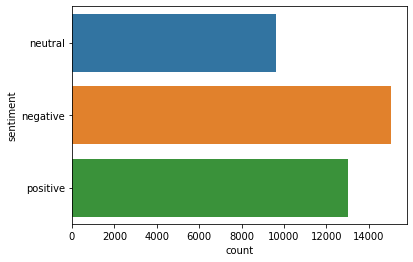

In [ ]:
sns.countplot(y='sentiment', data=df)

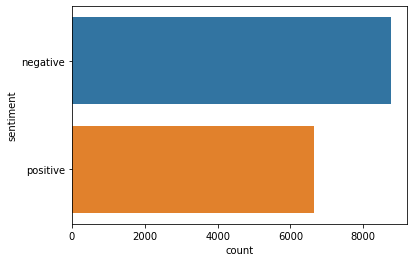

In [ ]:
sns.countplot(y='sentiment', data=train)

## `df`을 train, test로 나누기

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, random_state=42, stratify=df['sentiment'])
df_train.shape, df_test.shape

((30148, 2), (7537, 2))

## 데이터셋 합치기

In [ ]:
train = pd.concat([df_train, train])
test = pd.concat([df_test, test])

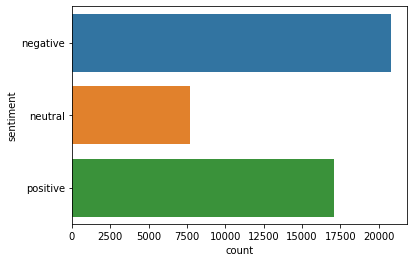

In [ ]:
sns.countplot(y='sentiment', data=train, order=['negative', 'neutral', 'positive'])

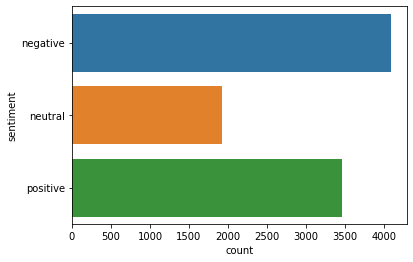

In [ ]:
sns.countplot(y='sentiment', data=test, order=['negative', 'neutral', 'positive'])

## 데이터 전처리(Preprocessing)

`lower`, `tokenize`, `lemmatize`

In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import text_hammer as th

from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def data_prep(data, text):
    lemmatizer = WordNetLemmatizer()

    corpus = []

    for line in data[text]:
        # 대문자 -> 소문자로 변경
        line = line.lower()
        # html tag 삭제
        line = th.remove_html_tags(line)
        # rt tag 삭제
        line = th.remove_rt(line)
        # url 삭제
        line = th.remove_urls(line)
        # 영어 소문자, 숫자, 공백만 남김
        line = re.sub("[^a-z0-9]", " ", line)
        # tokenize
        line = line.split()

        # lemmatization
        line = [lemmatizer.lemmatize(words)
                for words in line
                 if words not in stopwords.words("english")]
        
        line = " ".join(line)
        corpus.append(line)
    
    return corpus

### LabelEncoding

- `negative`: 0
- `neutral`: 1
- `positive`: 2

In [ ]:
encoding = {
    'negative' : 0,
    'neutral' : 1,
    'positive' : 2,
}

### Feature, Target 분리

- `text` = Feature: 분석할 대상
- `sentiment` = Target: 예측할 대상


In [ ]:
X_train = data_prep(train, 'text')
X_test = data_prep(test, 'text')

y_train = [encoding[key] for key in train['sentiment']]
y_test = [encoding[key] for key in test['sentiment']]

## BERT Model 만들기

### Reference
- https://github.com/amaiya/ktrain

In [9]:
import ktrain
from ktrain import text

In [13]:
model_arch ='bert-base-uncased'
MAXLEN = 512
trans = text.Transformer(model_arch, maxlen=MAXLEN, class_names= ['negative', 'neutral', 'positive'])

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [1]:
train_data = trans.preprocess_train(X_train,y_train)
test_data = trans.preprocess_test(X_test,y_test)

### 모델 학습

시간 관계상 최적의 hyperparameter 찾기를 전부 진행하는 것은 무리라고 판단 (1 epoch가 2시간 이상 소요됨)

-> BERT author가 추천한 `batch size`, `learning rate`, `epoch`중에서 골라 학습 진행하기로 함

- batch size : 8
- learning rate : 3e-5
- epoch : 4

In [ ]:
model = trans.get_classifier()

learner = ktrain.get_learner(model, train_data=train_data, val_data=test_data, batch_size=8)

In [ ]:
learner.fit_onecycle(3e-5, 4)



begin training using onecycle policy with max lr of 3e-05...
Epoch 1/4
5694/5694 [==============================] - 3263s 569ms/step - loss: 0.6736 - accuracy: 0.7024 - val_loss: 0.7009 - val_accuracy: 0.6948
Epoch 2/4
5694/5694 [==============================] - 3247s 569ms/step - loss: 0.5817 - accuracy: 0.7493 - val_loss: 0.7229 - val_accuracy: 0.6765
Epoch 3/4
5694/5694 [==============================] - 3246s 569ms/step - loss: 0.4982 - accuracy: 0.7951 - val_loss: 0.7201 - val_accuracy: 0.6891
Epoch 4/4
5694/5694 [==============================] - 3244s 568ms/step - loss: 0.2952 - accuracy: 0.8900 - val_loss: 0.9450 - val_accuracy: 0.6807


simulating training for different learning rates... this may take a few moments...
Epoch 1/6
5694/5694 [==============================] - 3219s 564ms/step - loss: 0.1746 - accuracy: 0.9402
Epoch 2/6
5694/5694 [==============================] - 3217s 564ms/step - loss: 0.2024 - accuracy: 0.9272
Epoch 3/6
5694/5694 [==============================] - 256s 43ms/step - loss: 0.3102 - accuracy: 0.8833


done.
Visually inspect loss plot and select learning rate associated with falling loss


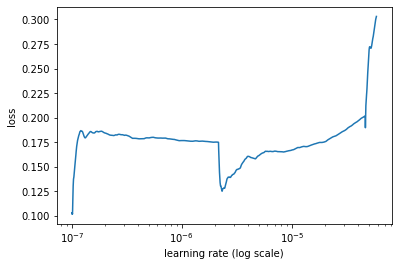

In [ ]:
# learner.lr_find(show_plot=True, max_epochs=6)

## 모델 성능 평가

In [ ]:
# baseline model accuracy
# 가장 많은 비중 차지하는 'negative'로 전부 예측하는 경우
from sklearn.metrics import accuracy_score

original = train['sentiment']

major = original.mode()[0]

baseline_pred = [major] * len(original)

print(f'baseline accuracy: {accuracy_score(original, baseline_pred) * 100 :.2f}%')

baseline accuracy: 56.79%


In [ ]:
# confusion matrix
learner.validate(val_data=test_data, class_names=['negative', 'neutral', 'positive'])

              precision    recall  f1-score   support

    negative       0.73      0.77      0.75      4087
     neutral       0.48      0.40      0.44      1924
    positive       0.71      0.73      0.72      3460

    accuracy                           0.68      9471
   macro avg       0.64      0.63      0.64      9471
weighted avg       0.67      0.68      0.68      9471



array([[3160,  429,  498],
       [ 642,  770,  512],
       [ 542,  401, 2517]])

## 새로운 데이터 예측

이전에 만들었던 LSTM 모델보다 전체적인 성능은 낮지만, 새로운 데이터에 대해서는 더 정확하게 예측함

-> 엄밀하게 말하자면 데이터셋이 다르기 때문에 정확한 성능 비교를 하기는 무리 (같은 데이터셋을 학습했을 때 성능을 비교해야 함)

> 그럼에도 같은 문장을 넣었을 때 좀 더 정확하게 분석한다는 것에는 어느정도 의의가 있다고 할 수 있음


### Section 4 모델의 한계점
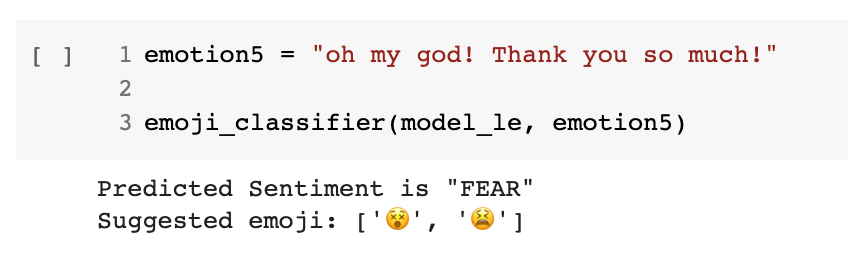
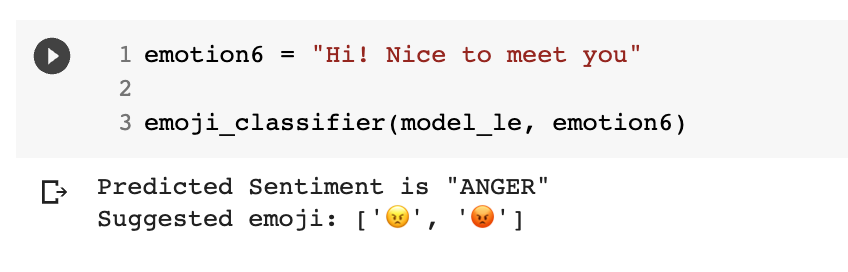

-> 문장의 뉘앙스를 잘 파악하지 못하고, 엉뚱한 감정으로 분류하는 경우 다수 발생

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc=trans)

In [ ]:
predictor.predict('Jesus Christ is the central figure of Christianity.')

'neutral'

In [ ]:
# save model for next time
predictor.save('/tmp/my_bert_predictor')

In [17]:
# reload the saved model
loaded_pred = ktrain.load_predictor('/tmp/my_bert_predictor')

In [ ]:
loaded_pred.predict('Jesus Christ is the central figure of Christianity.')

'neutral'

### Section 6 BERT 모델

같은 단어가 들어가도 문맥에 따라 다른 감정임을 파악할 수 있음

In [ ]:
loaded_pred.predict('oh my god! That is rediculous!')

'negative'

In [ ]:
loaded_pred.predict('oh my god! Thank you so much!')

'positive'

Section 4 모델에서 잘못 분류되었던 문장도 어느정도 정확하게 분석함

In [ ]:
loaded_pred.predict('Hi! Nice to meet you')

'positive'

In [ ]:
loaded_pred.predict('I\'ve been to italy last year.')

'neutral'

###  Section 6 모델 성능 향상에 영향을 미친 요인

- 전체 데이터의 수가 2배 이상 증가했다는 점
- 세세한 감정으로 나누지 않고 negative, positive, neutral로 좀 더 명확하게 구분
- pre-trained BERT 모델의 성능

## 핵심 keyword 추출 알고리즘

Extractive Approaches 중 하나인 `KeyBERT` 활용

### Reference
https://github.com/MaartenGr/KeyBERT

In [11]:
!pip3 install torch torchvision

In [12]:
!pip install keybert

     |████████████████████████████████| 78 kB 3.7 MB/s 
     |████████████████████████████████| 214 kB 10.7 MB/s 
     |████████████████████████████████| 51 kB 6.3 MB/s 
  Created wheel for keybert: filename=keybert-0.5.0-py3-none-any.whl size=20491 sha256=7c941692035834fab270b935fe5f279d4e8983a57f03e36670475188b5fdd610
  Stored in directory: /root/.cache/pip/wheels/99/1f/3f/590d2997adbb2d0e1f82e8ee05d42d6910e92c3ed283015ff8
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=b21c23f8f6d88bc87a4c280a86afbba2701db74e2fc2084ec22f5ccde1b328c6
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built keybert sentence-transformers


In [ ]:
import torch

In [ ]:
x = torch.tensor([[1,2,3], [4,5,6], [7,8,9]])
print(x)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


In [ ]:
from keybert import KeyBERT

doc = 'Jesus Christ is the central figure of Christianity.'
kw_model = KeyBERT()
keyword = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=3) # 1단어로 구성된 가장 연관성 높은 keyword 3개 추출

In [ ]:
keyword

[('christianity', 0.5532), ('jesus', 0.4017), ('christ', 0.3874)]

## 인스타 포스팅 생성기(po_sta) 구현

텍스트가 주어지면, 감정 분석을 통해 나온 감정에 해당하는 이미지를 보여주고, 관련 해시태그 추천해줌

In [ ]:
def po_sta(text):
    # importing library for showing image
    from IPython.display import Image

    # sentiment analysis
    emotion_predictor = ktrain.load_predictor('/tmp/my_bert_predictor')
    prediction = emotion_predictor.predict(text)

    # keyword extraction
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=3)
    keyword = ['#' + keyword[0] for keyword in keywords]

    print(f'Your post content:\n{text}\n') # original post 내용을 출력
    print(f'Suggested hashtag for this post:\n{keyword}\n\n') # 추천하는 해시태그 3개 출력

    # show image that goes well w/ predicted sentiment
    if prediction == 'negative':
        return Image('/content/drive/MyDrive/Section6/cp_1/image/negative.png', width=300, height=300)
    elif prediction == 'neutral':
        return Image('/content/drive/MyDrive/Section6/cp_1/image/neutral.png', width=300, height=300)
    else:
        return Image('/content/drive/MyDrive/Section6/cp_1/image/positive.png', width=300, height=300)


Your post content:
Jesus Christ is the central figure of Christianity.

Suggested hashtag for this post:
['#christianity', '#jesus', '#christ']




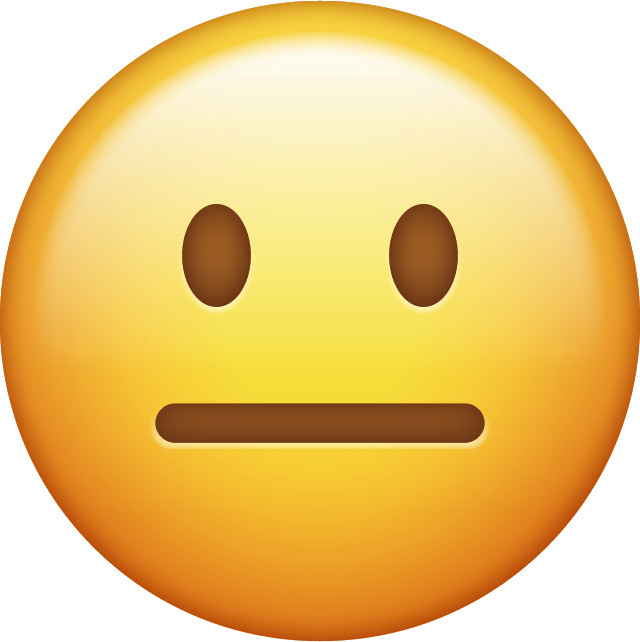

In [ ]:
po_sta('Jesus Christ is the central figure of Christianity.')

Your post content:
oh my god! Thank you so much!

Suggested hashtag for this post:
['#thank', '#god', '#oh']




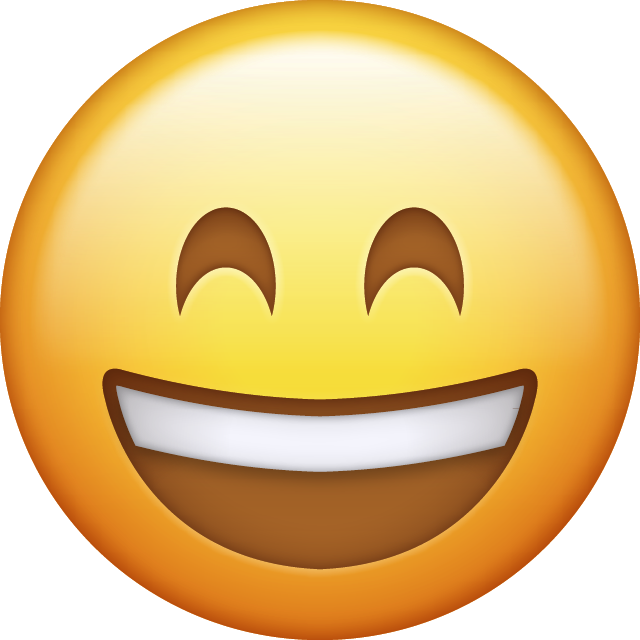

In [ ]:
po_sta('oh my god! Thank you so much!')

Your post content:
oh my god! That is rediculous! I want to get a refund RIGHT NOW!!

Suggested hashtag for this post:
['#refund', '#rediculous', '#right']




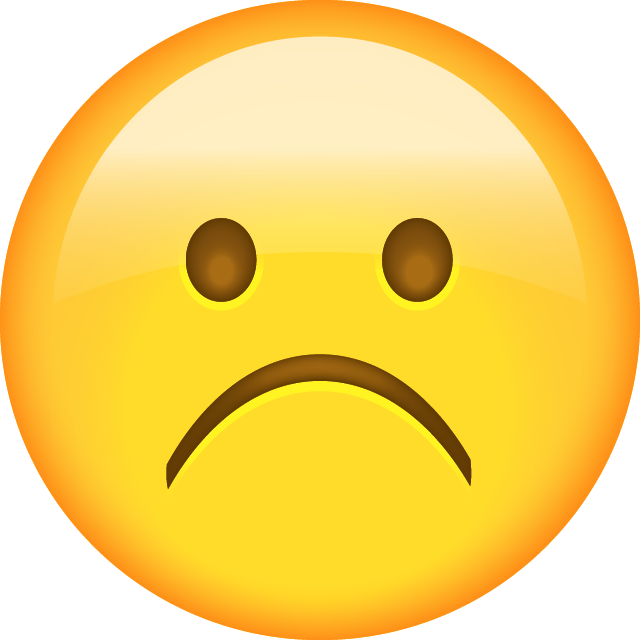

In [ ]:
po_sta('oh my god! That is rediculous! I want to get a refund RIGHT NOW!!')

## 한계점


> **한정된 언어지원 및 호환성**

현재는 영어로된 텍스트로만 학습을 시켜 다른 언어에는 적용하기 어려움 + 웹 어플리케이션 구현하지 못함

> **세세한 감정 분류 어려움**

감정을 `negative`, `neutral`, `positive`로만 분류하다보니 감정 간의 세밀한 차이를 구분하지 못함

> **해시태그 추천의 한계**

`KeyBERT` 모델은 주어진 텍스트를 가장 잘 설명해주는 키워드를 추출해주지만, 그 단어는 텍스트에 존재하는 것으로 한정됨


## 보완방법

> **웹 어플리케이션 제작**

실생활에서도 쓸 수 있도록 웹 어플리케이션으로 제작

> **데이터 확보**

다양한 언어, 세세한 감정을 커버하기 위해서는 더 많은 데이터를 확보하여 학습하는 것이 필요함

> **키워드 추출 방법 중** `abstractive approaches` **시도**

문서 요약의 방법 중 하나로, 사람이 요약하는 것 처럼 문서 내용을 전체적으로 보고 요약문을 생성함 -> 텍스트에는 등장하지 않지만 이를 잘 설명하는 키워드를 추출해낼 수 있음

단, 이 방법은 `supervised-learning`이므로 labeling이 필요함

## 발전 방향

- 단순히 감정에 해당하는 이미지를 제시하는 것을 넘어서 관련 키워드를 시각화 할 수 있는 GAN 모델 구현
